## Goal: Correlate the number of variants from known (v47) SS-proximal regions (+-1.6kb) with the number of added SJs uniq to personalized GRCh38s

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

1097448
1422991


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


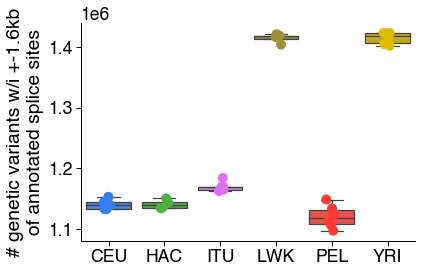

In [4]:
# load the nvars
var_df = pd.read_csv(proc_cfg(config['1000g']['n_ss_intersect_summary'], od), sep='\t')
var_df['cell_line_id'] = var_df.cell_line_id.str.rsplit('/', expand=True, n=1)[1]

# range
print(var_df.n_vars.min())
print(var_df.n_vars.max())

var_df = var_df.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# plot n_vars by pop
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=var_df.population.unique().tolist())
ax = sns.boxplot(var_df,
            x='population',
            y='n_vars',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='n_vars', data=var_df, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [5]:
# make a df to hold the different corr. values
corr_df = pd.DataFrame()

In [6]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel sjs and count per cell line
temp = df.loc[df.junction_novelty=='novel']

# get only the detection from mapping
temp = temp[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_novel_sj'] = temp.groupby('cell_line_id')['sj_id'].transform('nunique')

# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_novel_sj'] = temp.groupby('cell_line_id')['sj_id'].transform('nunique')

## Personalized-GRCh38-specific and novel

0.1880878635999897
0.31956844481234564

0.21379310344827587
0.256621454939998


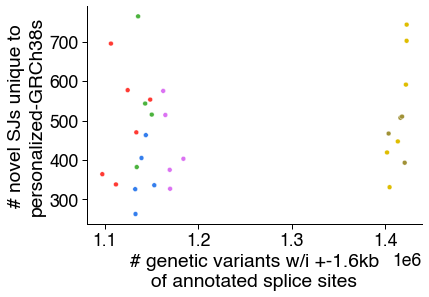

In [7]:
# add number of non-hg38 discovered novel SJs
var_df = var_df.merge(temp[['cell_line_id', 'n_non_hg38_novel_sj']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
ax = sns.scatterplot(var_df, y='n_non_hg38_novel_sj', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# novel SJs unique to\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_non_hg38_novel_sj.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_non_hg38_novel_sj', 'uniq', 'novel'],
                          [rho, rho_p, 'spearman', 'n_non_hg38_novel_sj', 'uniq', 'novel']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## Personalized-GRCh38 novel

-0.09604947745709612
0.6136287391848039

0.029143492769744164
0.8784968881047431


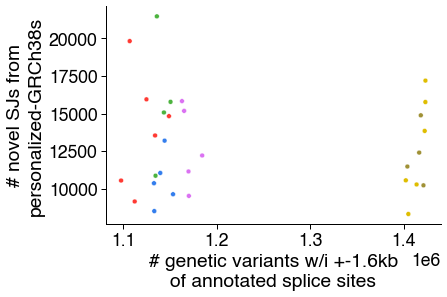

In [8]:
# add number of non-hg38 discovered novel SJs
var_df = var_df.merge(temp[['cell_line_id', 'n_novel_sj']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
ax = sns.scatterplot(var_df, y='n_novel_sj', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# novel SJs from\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_novel_sj.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_novel_sj', 'all', 'novel'],
                          [rho, rho_p, 'spearman', 'n_novel_sj', 'all', 'novel']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)

## All SJs from personalized grch38 (both known and novel allowed)

In [9]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# # 1.5 only novel sjs and count per cell line
# temp = df.loc[df.junction_novelty=='novel']

# get only the detection from mapping
temp = df[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_sj'] = temp.groupby('cell_line_id')['sj_id'].transform('nunique')

# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_sj'] = temp.groupby('cell_line_id')['sj_id'].transform('nunique')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


-0.013081224453244852
0.9453023444074942

0.056729699666295874
0.7658877665230976


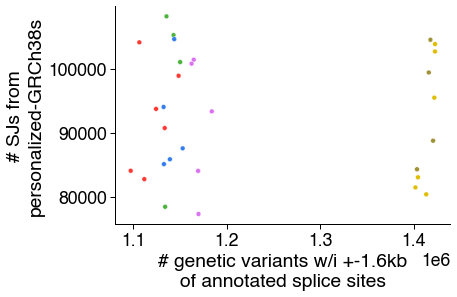

In [10]:
# add number of non-hg38 discovered novel SJs
var_df = var_df.merge(temp[['cell_line_id', 'n_sj']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
ax = sns.scatterplot(var_df, y='n_sj', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# SJs from\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_sj.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_sj', 'all', 'all'],
                          [rho, rho_p, 'spearman', 'n_sj', 'all', 'all']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)


ooa


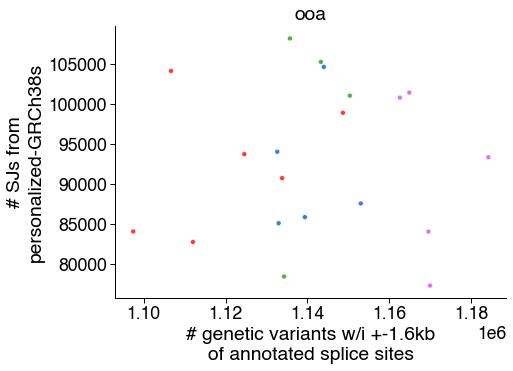

0.04550760085583922
0.848909592655368

0.03458646616541353
0.8849015088305833

afr


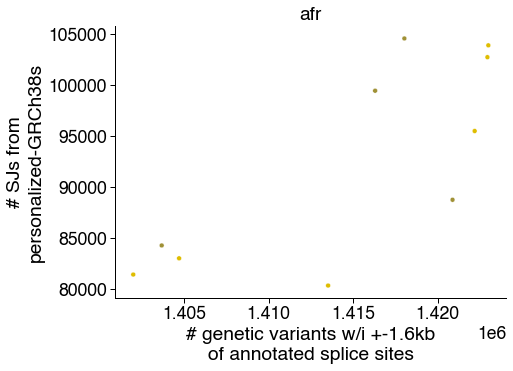

0.7664840197344684
0.009706497746320437

0.7333333333333332
0.01580059625057158


<Figure size 504x360 with 0 Axes>

In [26]:
# split this one on afr. vs. ooa

# add number of non-hg38 discovered novel SJs
for group in ['ooa', 'afr']:
    afr_pops = ['LWK', 'YRI']
    print()
    print(group)
    if group == 'afr':
        temp2 = var_df.loc[var_df.population.isin(afr_pops)]
    elif group == 'ooa':
        temp2 = var_df.loc[~var_df.population.isin(afr_pops)]

    # correlate!
    ax = sns.scatterplot(temp2, y='n_sj', x='n_vars',
                        hue='population',
                        palette=c_dict)
    ax.set(ylabel='# SJs from\npersonalized-GRCh38s',
           xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites',
           title=group)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend([],[], frameon=False)
    plt.show()
    plt.clf()

    x = temp2.n_sj.tolist()
    y = temp2.n_vars.tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)

    print(r)
    print(r_p)

    print()

    print(rho)
    print(rho_p)


ITU


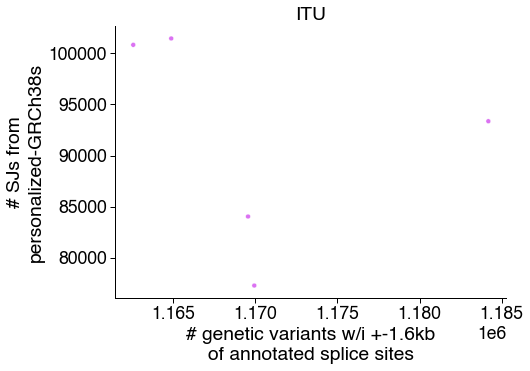

-0.25205118870814697
0.6825096124072842

-0.6
0.28475697986529375

PEL


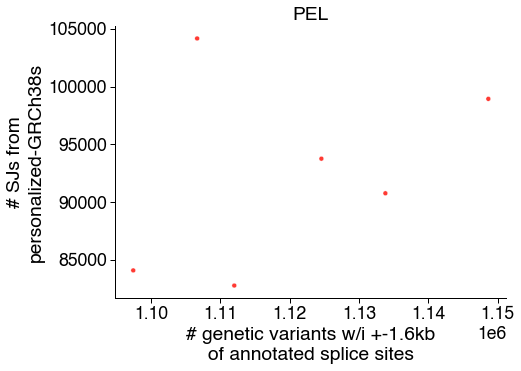

0.35372707700145933
0.4915390536124961

0.2571428571428572
0.6227871720116618

HAC


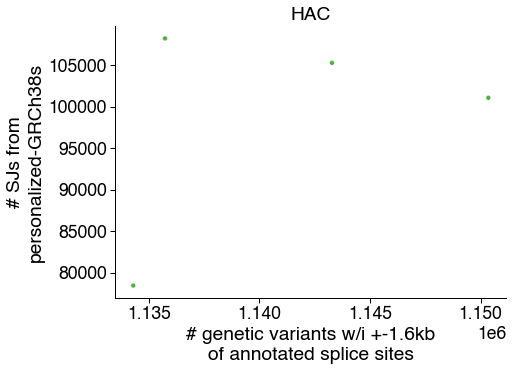

0.4071530675471791
0.5928469324528209

0.19999999999999998
0.8

LWK


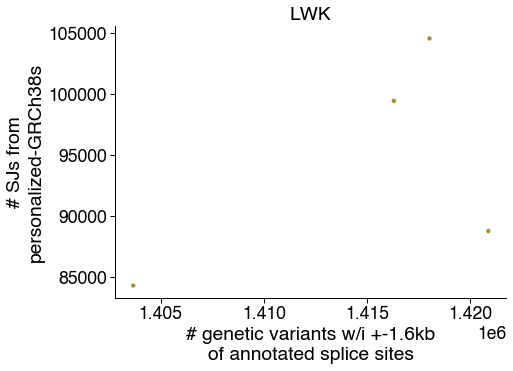

0.5554853467471252
0.44451465325287476

0.39999999999999997
0.6

YRI


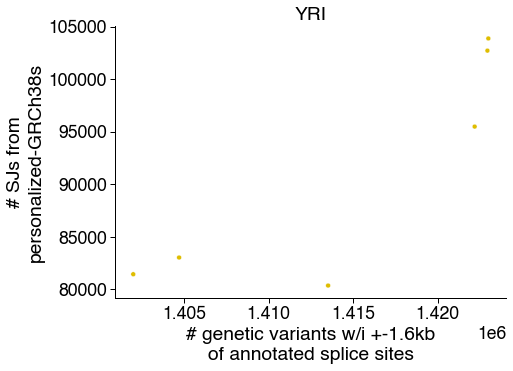

0.868444874945261
0.024821730500928837

0.8285714285714287
0.04156268221574334

CEU


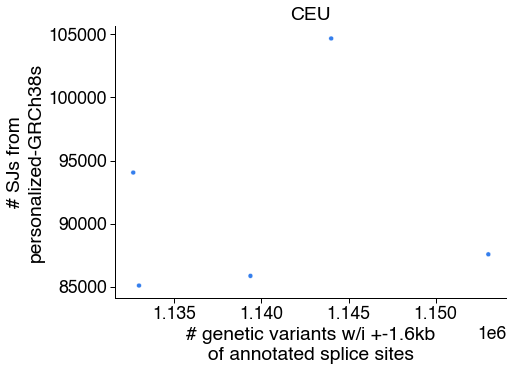

0.11306428865510687
0.8563493825773949

0.19999999999999998
0.747060078104662


<Figure size 504x360 with 0 Axes>

In [27]:
# split this one on population

# add number of non-hg38 discovered novel SJs
for group in var_df.population.unique().tolist():
    print()
    print(group)
    temp2 = var_df.loc[var_df.population==group]
    # temp2 = var_df.loc[~var_df.population.isin(afr_pops)]

    # correlate!
    ax = sns.scatterplot(temp2, y='n_sj', x='n_vars',
                        hue='population',
                        palette=c_dict)
    ax.set(ylabel='# SJs from\npersonalized-GRCh38s',
           xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites',
           title=group)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend([],[], frameon=False)
    plt.show()
    plt.clf()

    x = temp2.n_sj.tolist()
    y = temp2.n_vars.tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)

    print(r)
    print(r_p)

    print()

    print(rho)
    print(rho_p)

## Personalized-GRCh38-specific ICs (known+novel)

0.3438757875521803
0.06279307437259532

0.35554566912634433
0.053831288858361526


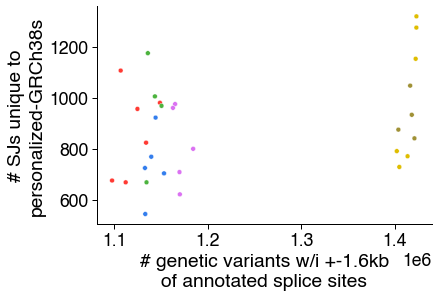

In [11]:
# add number of non-hg38 discovered novel SJs
var_df = var_df.merge(temp[['cell_line_id', 'n_non_hg38_sj']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
ax = sns.scatterplot(var_df, y='n_non_hg38_sj', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# SJs unique to\npersonalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend([],[], frameon=False)

x = var_df.n_non_hg38_sj.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_non_hg38_sj', 'uniq', 'all'],
                          [rho, rho_p, 'spearman', 'n_non_hg38_sj', 'uniq', 'all']],
                        columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
corr_df = pd.concat([corr_df, temp_corr], axis=0)


ooa


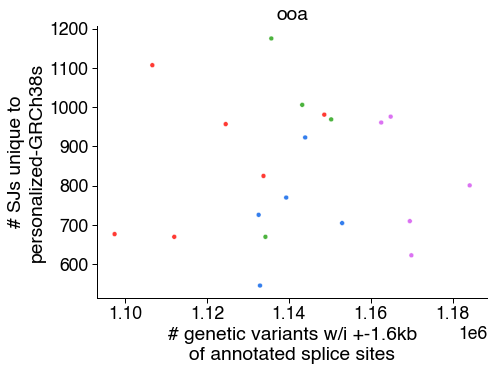

-0.00897971526248436
0.9700279309775146

0.06694246430534137
0.7791602646232713

afr


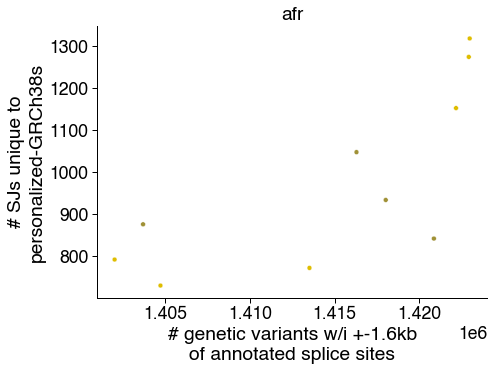

0.7431829997905277
0.013770953445259195

0.7939393939393938
0.0060999233136969115


<Figure size 504x360 with 0 Axes>

In [23]:
# split this one on afr. vs. ooa

# add number of non-hg38 discovered novel SJs
for group in ['ooa', 'afr']:
    afr_pops = ['LWK', 'YRI']
    print()
    print(group)
    if group == 'afr':
        temp2 = var_df.loc[var_df.population.isin(afr_pops)]
    elif group == 'ooa':
        temp2 = var_df.loc[~var_df.population.isin(afr_pops)]

    # correlate!
    ax = sns.scatterplot(temp2, y='n_non_hg38_sj', x='n_vars',
                        hue='population',
                        palette=c_dict)
    ax.set(ylabel='# SJs unique to\npersonalized-GRCh38s',
           xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites',
           title=group)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend([],[], frameon=False)
    plt.show()
    plt.clf()

    x = temp2.n_non_hg38_sj.tolist()
    y = temp2.n_vars.tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)

    print(r)
    print(r_p)

    print()

    print(rho)
    print(rho_p)

    temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_non_hg38_sj', 'uniq', 'all'],
                              [rho, rho_p, 'spearman', 'n_non_hg38_sj', 'uniq', 'all']],
                            columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
    corr_df = pd.concat([corr_df, temp_corr], axis=0)


ITU


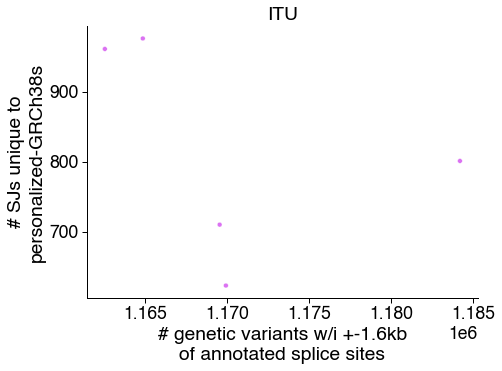

-0.3946735511942928
0.5108550804559246

-0.6
0.28475697986529375

PEL


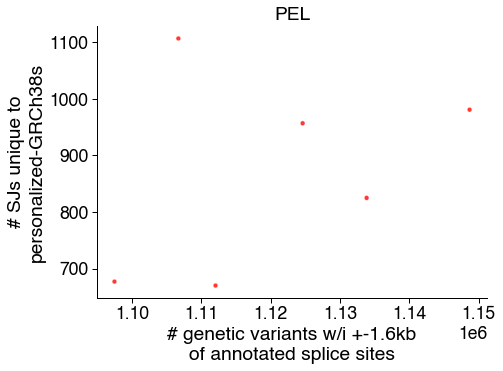

0.3455373133594164
0.5023219225275168

0.2571428571428572
0.6227871720116618

HAC


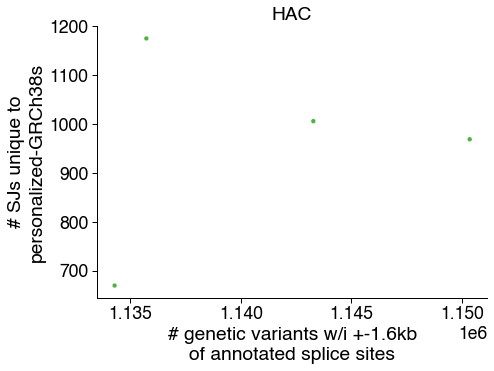

0.21354535190929427
0.7864546480907058

0.19999999999999998
0.8

LWK


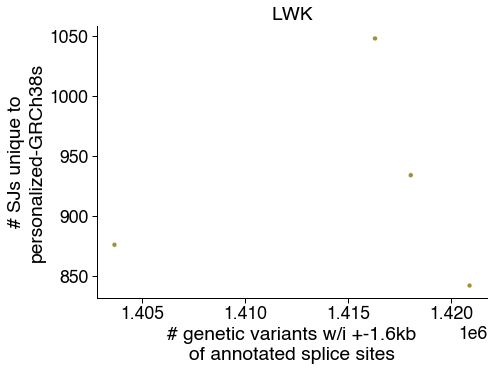

0.12327263753190215
0.8767273624680978

-0.39999999999999997
0.6

YRI


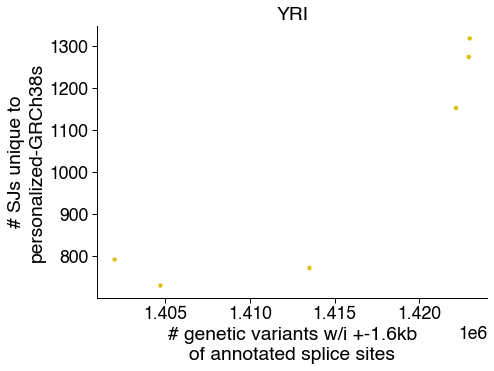

0.9003656143007166
0.014395980408385101

0.8285714285714287
0.04156268221574334

CEU


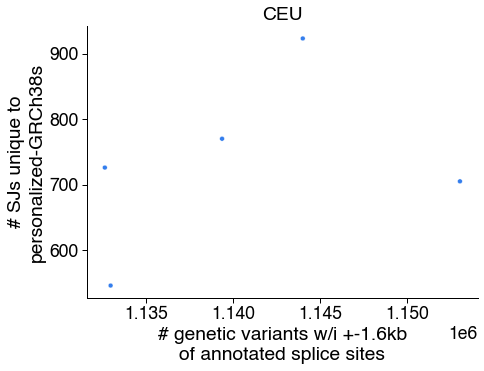

0.37747409232654033
0.531055889618942

0.19999999999999998
0.747060078104662


<Figure size 504x360 with 0 Axes>

In [24]:
# split this one on population

# add number of non-hg38 discovered novel SJs
for group in var_df.population.unique().tolist():
    print()
    print(group)
    temp2 = var_df.loc[var_df.population==group]
    # temp2 = var_df.loc[~var_df.population.isin(afr_pops)]

    # correlate!
    ax = sns.scatterplot(temp2, y='n_non_hg38_sj', x='n_vars',
                        hue='population',
                        palette=c_dict)
    ax.set(ylabel='# SJs unique to\npersonalized-GRCh38s',
           xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites',
           title=group)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend([],[], frameon=False)
    plt.show()
    plt.clf()

    x = temp2.n_non_hg38_sj.tolist()
    y = temp2.n_vars.tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)

    print(r)
    print(r_p)

    print()

    print(rho)
    print(rho_p)

    temp_corr = pd.DataFrame([[r, r_p, 'pearson', 'n_non_hg38_sj', 'uniq', 'all'],
                              [rho, rho_p, 'spearman', 'n_non_hg38_sj', 'uniq', 'all']],
                            columns=['corr', 'pval', 'corr_type', 'comparison', 'uniq_or_all', 'novelty'])
    corr_df = pd.concat([corr_df, temp_corr], axis=0)

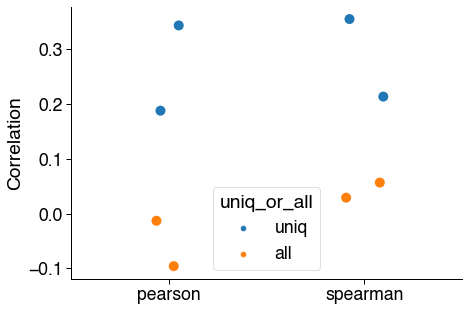

In [21]:
init_plot_settings(aspect='rectangle')

# ax = sns.boxplot(corr_df,
#             x='corr_type',
#             y='corr',
#             hue='uniq_or_all',
#             saturation=0.75,
#             showfliers=False)
ax = sns.stripplot(x='corr_type', y='corr', data=corr_df, jitter=True,
              hue='uniq_or_all',
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='Correlation')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

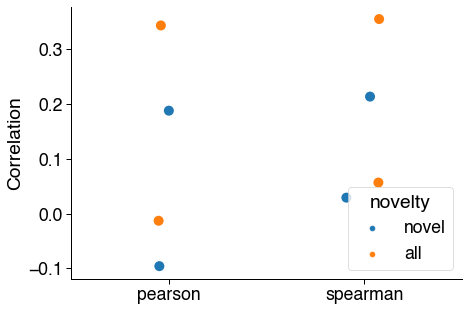

In [19]:
init_plot_settings(aspect='rectangle')

# ax = sns.boxplot(corr_df,
#             x='corr_type',
#             y='corr',
# hue='novelty',
#                  saturation=0.75,
#             showfliers=False)
ax =sns.stripplot(x='corr_type', y='corr', data=corr_df, jitter=True,
              hue='novelty',
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='Correlation')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [14]:
corr_df.sort_values(by='corr', ascending=False)

,corr,pval,corr_type,comparison,uniq_or_all,novelty
1,0.355546,0.053831,spearman,n_non_hg38_sj,uniq,all
0,0.343876,0.062793,pearson,n_non_hg38_sj,uniq,all
1,0.213793,0.256621,spearman,n_non_hg38_novel_sj,uniq,novel
0,0.188088,0.319568,pearson,n_non_hg38_novel_sj,uniq,novel
1,0.056730,0.765888,spearman,n_sj,all,all
1,0.029143,0.878497,spearman,n_novel_sj,all,novel
0,-0.013081,0.945302,pearson,n_sj,all,all
0,-0.096049,0.613629,pearson,n_novel_sj,all,novel
